## Downloading NetCDF data for a given date

For downloading data from the Climate Data Store (CDS), we will use the `earthkit.data` package which includes a way to programmatically retreive the data from the CDS API. 

In [1]:
import earthkit.data

### Authenticating with your ECMWF user

Before we can download the dataset programmatically, we need to authenticate using our user credentials:

- Go to the [CDSAPI Setup page](https://cds.climate.copernicus.eu/how-to-api) and make sure to login.
- Once logged in, scroll down to the section "Setup the CDS API personal access token". 
  - This should show your login credentials, and look something like this:

        url: https://cds.climate.copernicus.eu/api
        key: xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

- Copy those two lines to a file `.cdsapirc` in your user's $HOME directory.

### Constructing the request query

Earthkit provides a convenience method for retrieving data from CDS, `earthkit.data.from_source("cds", ...)`. To obtain the correct parameters to use for the data query, you can return to the data request page you filled out in the tutorial for [manually downloading CDS data](../getting-data/climate-data-store.ipynb). 

- At the bottom of the page, click "Show API Request Code" in the "API Request" section.
- This should show something like this:

    ![Screenshot of CDS API request code](./images/ecmwf-cds-api-request-params.png)

        import cdsapi

        dataset = "reanalysis-era5-land"
        request = {
            "variable": ["2m_temperature"],
            "year": "2025",
            "month": "01",
            "day": [
                "01", "02", "03",
                "04", "05", "06",
                "07", "08", "09",
                "10", "11", "12",
                "13", "14", "15",
                "16", "17", "18",
                "19", "20", "21",
                "22", "23", "24",
                "25", "26", "27",
                "28", "29", "30",
                "31",
            ],
            "time": [
                "00:00", "01:00", "02:00",
                "03:00", "04:00", "05:00",
                "06:00", "07:00", "08:00",
                "09:00", "10:00", "11:00",
                "12:00", "13:00", "14:00",
                "15:00", "16:00", "17:00",
                "18:00", "19:00", "20:00",
                "21:00", "22:00", "23:00"
            ],
            "data_format": "netcdf",
            "download_format": "unarchived",
            "area": [-9.223115, 26.677001, -17.666611, 43.387206]
        }
        
        client = cdsapi.Client()
        client.retrieve(dataset, request).download()

Since `earthkit` uses `cdsapi` in the background, we can copy these parameter values to fill in the parameters required by `earthkit`:

In [12]:
data = earthkit.data.from_source("cds",
    "reanalysis-era5-land",
    {
        "variable": ["2m_temperature"],
        "year": "2025",
        "month": "01",
        "day": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12",
            "13", "14", "15",
            "16", "17", "18",
            "19", "20", "21",
            "22", "23", "24",
            "25", "26", "27",
            "28", "29", "30",
            "31",
        ],
        "time": [
            "00:00", "01:00", "02:00",
            "03:00", "04:00", "05:00",
            "06:00", "07:00", "08:00",
            "09:00", "10:00", "11:00",
            "12:00", "13:00", "14:00",
            "15:00", "16:00", "17:00",
            "18:00", "19:00", "20:00",
            "21:00", "22:00", "23:00"
        ],
        "data_format": "netcdf",
        "download_format": "unarchived",
        "area": [-9.223115, 26.677001, -17.666611, 43.387206]
    }
)

2025-09-24 21:22:22,506 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-24 21:22:22,508 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-24 21:22:22,701 INFO [2025-09-03T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-09-24 21:22:22,703 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-09-24 21:22:22,897 INFO Request ID is 4b1f27bd-53f9-425b-bbdf-ef55b64569c9
2025-09-24 21:22:22,982 INFO status has been updated to accepted
2025-09-24 21:22:31,764 INFO status has been updated to running
2025-09-24 21:24:17,656 INFO status has been updated to successful


4e2191a16b1669705c19e1a708bf497d.nc:   0%|          | 0.00/18.7M [00:00<?, ?B/s]

### Inspect the data

Once the data has finished downloaded, you can then inspect the data: 

In [13]:
data_array = data.to_xarray()
data_array

<xarray.Dataset> Size: 43MB
Dimensions:     (valid_time: 744, latitude: 85, longitude: 168)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2025-01-01 ... 2025-01-31T23:...
  * latitude    (latitude) float64 680B -9.266 -9.366 -9.466 ... -17.57 -17.67
  * longitude   (longitude) float64 1kB 26.68 26.78 26.88 ... 43.18 43.28 43.38
    expver      (valid_time) <U4 12kB dask.array<chunksize=(744,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 42MB dask.array<chunksize=(372, 43, 84), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-09-24T19:24 GRIB to CDM+CF via cfgrib-0.9.1...

Let's select a snapshot of the temperature on the 13th of January at noon:

In [21]:
temp_snapshot = data_array['t2m'].sel(valid_time='2025-01-13T12:00:00')
print(temp_snapshot)
import numpy as np
numpy_array = temp_snapshot.to_numpy()
np.histogram(numpy_array[~np.isnan(numpy_array)])

<xarray.DataArray 't2m' (latitude: 85, longitude: 168)> Size: 57kB
dask.array<getitem, shape=(85, 168), dtype=float32, chunksize=(43, 84), chunktype=numpy.ndarray>
Coordinates:
    number      int64 8B ...
    valid_time  datetime64[ns] 8B 2025-01-13T12:00:00
  * latitude    (latitude) float64 680B -9.266 -9.366 -9.466 ... -17.57 -17.67
  * longitude   (longitude) float64 1kB 26.68 26.78 26.88 ... 43.18 43.28 43.38
    expver      <U4 16B dask.array<chunksize=(), meta=np.ndarray>
Attributes: (12/32)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      14280
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                            

(array([  54,  172,  734, 1921, 3893, 2167, 1547,  594,  275,  110]),
 array([292.6682 , 294.61298, 296.55777, 298.50253, 300.44733, 302.3921 ,
        304.33685, 306.28165, 308.2264 , 310.1712 , 312.11597],
       dtype=float32))

Next, visualize the data to make sure it looks okay:

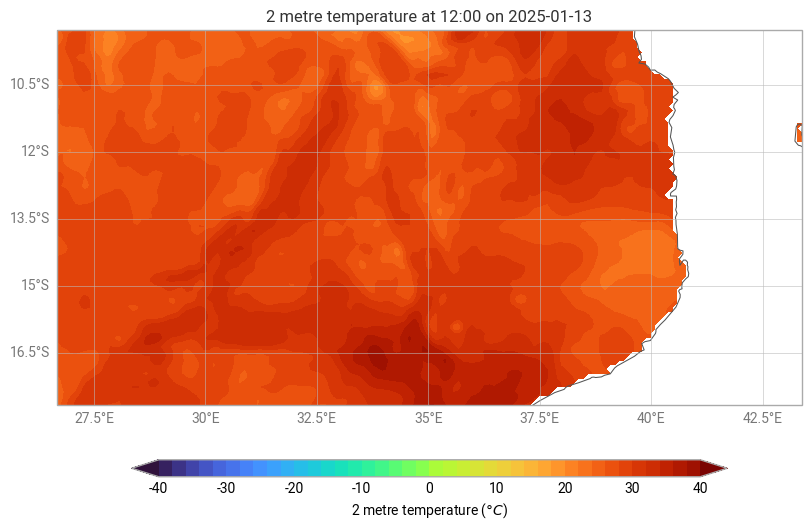

In [17]:
import earthkit.plots
earthkit.plots.quickplot(temp_snapshot, units='celsius').show()

### Save to file

Finally, save the downloaded data to a location of your choice:

In [16]:
data.save('../data/era5-land-hourly-temperature-2m-jan-2025-malawi.nc')

C:\Users\karimba\AppData\Local\Temp\ipykernel_34308\666576190.py:1: DeprecatedWarning: save is deprecated as of 0.13.0. Use to_target() instead
  data.save('../data/era5-land-hourly-temperature-2m-jan-2025-malawi.nc')


### How to download data for many months? 

One of the benefits of using earthkit to download CDS data, is that we can loop through the months we are interested in and download all with a single script. Here's one possible way of automatic this process: 

In [5]:
for x in []:
    print(x)